# Reading the data and resampling it

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading the data
df = pd.read_pickle("data.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149855 entries, 0 to 149854
Data columns (total 86 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              149855 non-null  int64  
 1   ID                 149855 non-null  int64  
 2   S15                149855 non-null  float64
 3   S17                149855 non-null  float64
 4   S13                149855 non-null  float64
 5   S5                 149855 non-null  float64
 6   S16                149855 non-null  float64
 7   S19                149855 non-null  float64
 8   S18                149855 non-null  float64
 9   EQUIPMENT_FAILURE  149855 non-null  int64  
 10  S8                 149855 non-null  float64
 11  AGE_OF_EQUIPMENT   149855 non-null  int64  
 12  TIME_SINCE_START   149855 non-null  float64
 13  too_soon           149855 non-null  int32  
 14  S15_mean           149855 non-null  float64
 15  S17_mean           149855 non-null  float64
 16  S1

In [4]:
X = df[[x for x in df.columns if x not in ['FAILURE_TARGET','EQUIPMENT_FAILURE', 'TIME_TO_FAILURE']]]
y = df[['FAILURE_TARGET']]

In [5]:
try:
    X = X.to_numpy()
    y = y.to_numpy().ravel()
except:
    pass

In [6]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
#Now since we want the valid and test size to be equal (10% each of overall data).
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [7]:
# Normalizing the data with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Resampling the data to balance the dataset
from sklearn.utils import resample
X_oversampled, y_oversampled = resample(X_train_scaled[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=X_train_scaled[y_train == 0].shape[0])
X_balanced = np.vstack((X_train_scaled[y_train == 0], X_oversampled))
y_balanced = np.hstack((y_train[y_train == 0], y_oversampled))

# Training the Models

In [9]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2022-06-23 16:19:57.244872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [10]:
# Generating relevant metrics to be placed in callback

from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test(y_true,y_pred):
    print(accuracy_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('tn',tn, 'fp',fp, 'fn',fn, 'tp',tp)
    print('f1', f1_score(y_true, y_pred))
    
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

# Modifiable parameters
lr = [1e-4,1e-3,1e-2]
batch = [128,256,512]

# Model
def get_model():

    model = Sequential()
    model.add(Dense(83,activation="relu"))
    model.add(Dense(40, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

model = get_model()
epochs = 75
count = 0
loss_all = np.zeros((len(lr)*len(batch),epochs))
val_loss_all = np.zeros((len(lr)*len(batch),epochs))
accuracy_all = np.zeros((len(lr)*len(batch),epochs))
val_accuracy_all = np.zeros((len(lr)*len(batch),epochs))
f1_all = np.zeros((len(lr)*len(batch),epochs))
val_f1_all = np.zeros((len(lr)*len(batch),epochs))

model_info = []

# Looping over the parameters to generate a new model and training instance
for j in range(0,len(batch)):
    for k in range(0,len(lr)):

        model = get_model()

        learnRate=lr[k]
        model.compile(optimizer=Adam(learning_rate=learnRate),loss="binary_crossentropy",metrics=["accuracy",f1_m])

        print("Model ",count,": ")
        print("Batch size: ",batch[j])
        print("Learning rate: ",lr[k])
        
        model_info.append((str(count),'lr = ' + str(learnRate),' batch_size= '+str(batch[j])))        
        
        history = model.fit(x=X_balanced, y=y_balanced,
            validation_data=(X_val_scaled, y_val),
            batch_size=batch[j],
            epochs=epochs,
            verbose=0)        
        
        y_pred = np.round(model.predict(X_val_scaled))
        test(y_val,y_pred)


        loss = history.history['loss']
        val_loss = history.history['val_loss']
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        f1 = history.history['f1_m']
        val_f1 = history.history['val_f1_m']

        loss_all[count,:] = loss
        val_loss_all[count,:] = val_loss
        accuracy_all[count,:] = accuracy
        val_accuracy_all[count,:] = val_accuracy
        f1_all[count,:] = f1
        val_f1_all[count,:] = val_f1
        

        count +=1
        print('')
        print('')
        print('------------------------------------------------------------')
        print('------------------------------------------------------------')
        print('------------------------------------------------------------')
        print('')
        print('')


2022-06-23 16:20:09.537324: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-23 16:20:09.728693: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-23 16:20:10.000298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 16:20:10.000584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2022-06-23 16:20:10.000627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-23 16:20:10.239185: I tensorflow/stream_executor/platform/d

Model  0 : 
Batch size:  128
Learning rate:  0.0001


2022-06-23 16:20:16.648150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-23 16:20:16.750391: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
2022-06-23 16:20:17.859954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-23 16:20:21.544766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


0.9842509175842509
[[14188   198]
 [   38   561]]
tn 14188 fp 198 fn 38 tp 561
f1 0.8262150220913107


------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


Model  1 : 
Batch size:  128
Learning rate:  0.001
0.9892559225892559
[[14258   128]
 [   33   566]]
tn 14258 fp 128 fn 33 tp 566
f1 0.8754833720030936


------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


Model  2 : 
Batch size:  128
Learning rate:  0.01
0.9788455121788455
[[14098   288]
 [   29   570]]
tn 14098 fp 288 fn 29 tp 570
f1 0.7824296499656829


------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


Model  3 : 
Batch size:  256
Learni

# Plotting Results

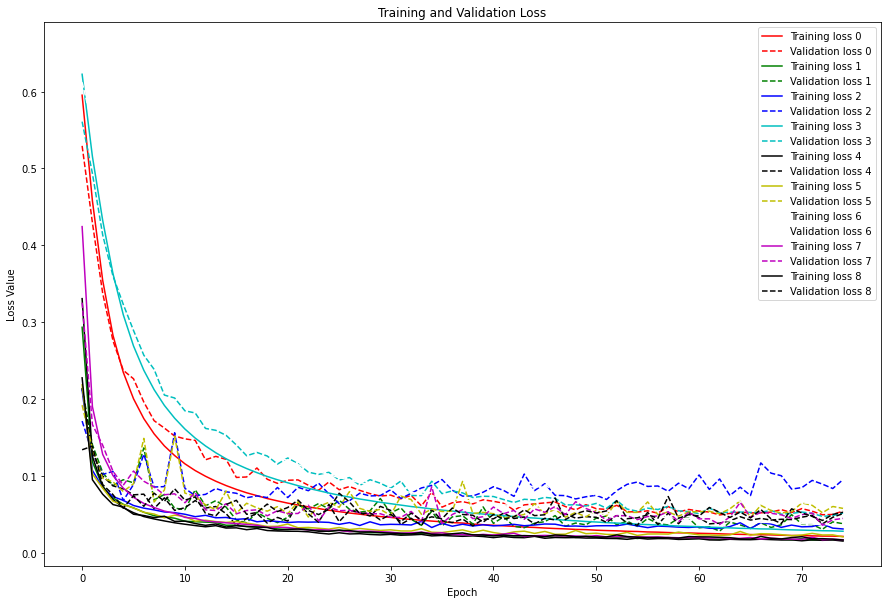

<Figure size 432x288 with 0 Axes>

In [373]:
from matplotlib import pylab
from pylab import *

fig = plt.figure(figsize=(15,10))

colors = ['r','g','b','c','k','y','w','m','k']
for i in range(len(lr)*len(batch)):
    plt.plot(history.epoch, loss_all[i],'-'+str(colors[i]), label='Training loss '+str(i))
    plt.plot(history.epoch, val_loss_all[i],'--'+str(colors[i]), label='Validation loss '+str(i))        

    
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.xlim([-0, 30])
#plt.ylim([0, 0.2])
plt.legend()
plt.show()
pylab.savefig('loss.png')


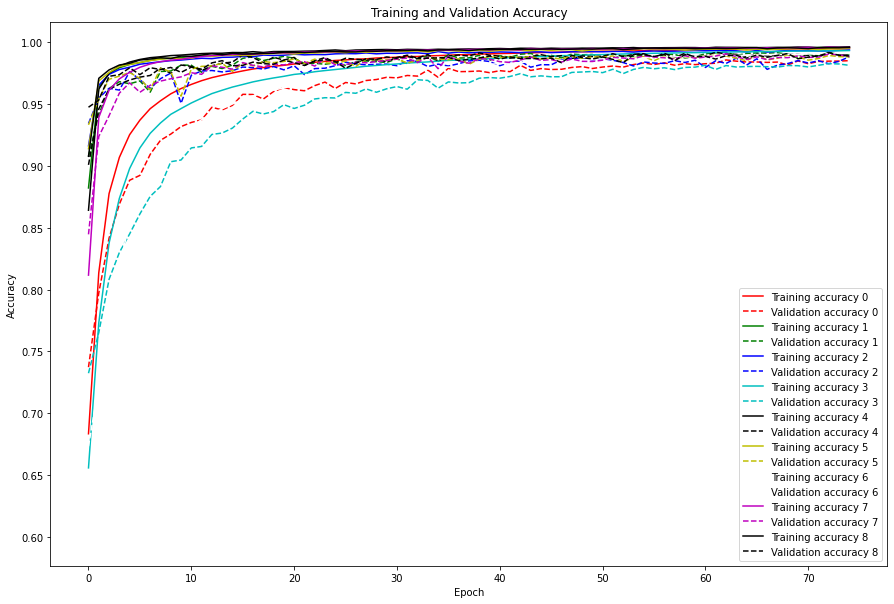

<Figure size 432x288 with 0 Axes>

In [370]:
fig = plt.figure(figsize=(15,10))

colors = ['r','g','b','c','k','y','w','m','k']
for i in range(len(lr)*len(batch)):
    plt.plot(history.epoch, accuracy_all[i],'-'+str(colors[i]), label='Training accuracy '+str(i))
    plt.plot(history.epoch, val_accuracy_all[i],'--'+str(colors[i]), label='Validation accuracy '+str(i))        

    
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.xlim([-0, 30])
#plt.ylim([0, 0.2])
plt.legend()
plt.show()
plt.savefig('accuracy.png',facecolor=fig.get_facecolor(), edgecolor='none')

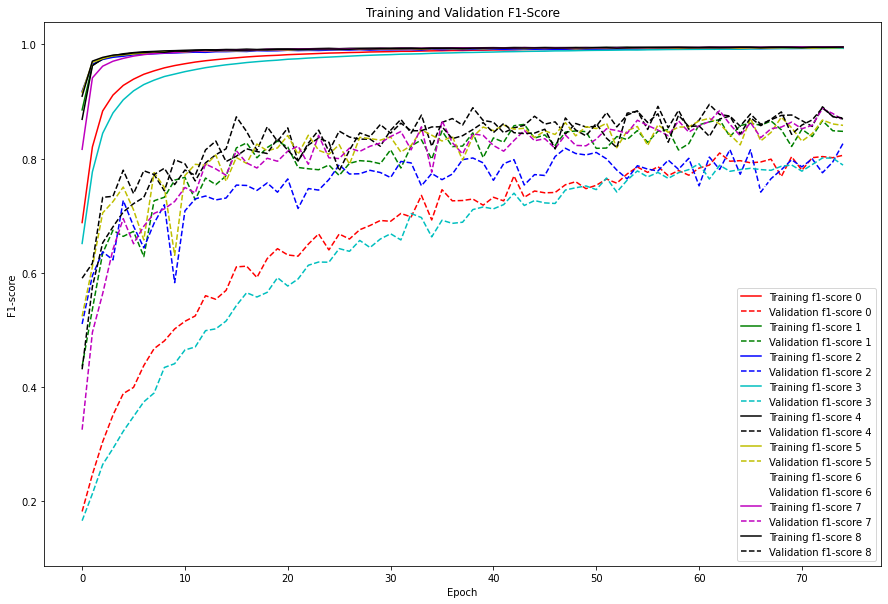

NameError: name 'pylab' is not defined

In [372]:
fig = plt.figure(figsize=(15,10))

colors = ['r','g','b','c','k','y','w','m','k']
for i in range(len(lr)*len(batch)):
    plt.plot(history.epoch, f1_all[i],'-'+str(colors[i]), label='Training f1-score '+str(i))
    plt.plot(history.epoch, val_f1_all[i],'--'+str(colors[i]), label='Validation f1-score '+str(i))        

    
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
#plt.xlim([-0, 30])
#plt.ylim([0.2, 1])
plt.legend()
plt.show()
pylab.savefig('f1.png')